# Binary classification risk control - Theoretical tests prototype

In [1]:
%reload_ext autoreload
%autoreload 2

In [47]:
import numpy as np
import itertools
from matplotlib import pyplot as plt
from collections import Counter

from mapie.risk_control_draft import BinaryClassificationController

In [48]:
class RandomClassifier:
    def __init__(self, seed=42, threshold=0.5):
        self.seed = seed
        self.threshold = threshold

    def _get_prob(self, x):
        local_seed = hash((x, self.seed)) % (2**32)
        rng = np.random.RandomState(local_seed)
        return np.round(rng.rand(), 2)

    def predict_proba(self, X):
        probs = np.array([self._get_prob(x) for x in X])
        return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

In [123]:
N = 100  # size of the calibration set
p = 0.5  # proportion of positives in the calibration set
metric = "precision"
target_level = 0.8
predict_params = np.linspace(0, 0.99, 100)
confidence_level = 0.7

n_repeats = 100

Number of valid thresholds according to LTT across all iterations: 105
Number of actual valid thresholds across all iterations: 0


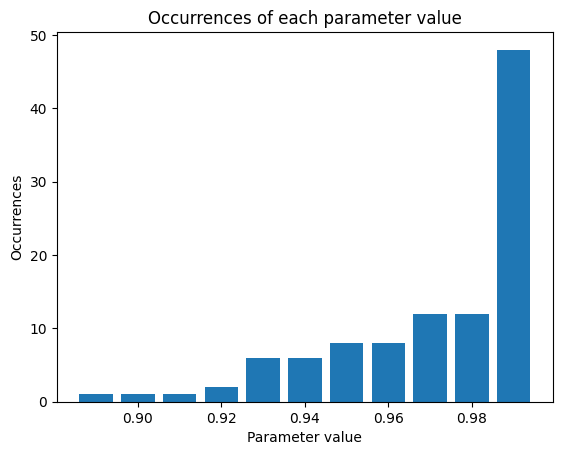

In [124]:
clf = RandomClassifier()

if metric == "precision":
    theoretical_value = p
elif metric == "recall":
    theoretical_value = 1 - clf.threshold

all_valid_parameters = []

for _ in range(n_repeats):

    X_calibrate = list(range(1, N+1))
    y_calibrate = [1] * int(p*N) + [0] * (N - int(p*N))
    np.random.shuffle(y_calibrate)

    controller = BinaryClassificationController(
        fitted_binary_classifier=clf,
        metric="precision",
        target_level=target_level,
        confidence_level=confidence_level,
    )
    controller.calibrate(X_calibrate, y_calibrate)

    valid_parameters = controller.valid_thresholds
    all_valid_parameters.append(valid_parameters)

all_valid_parameters = np.concatenate([x for x in all_valid_parameters if x.size > 0]) if any(x.size > 0 for x in all_valid_parameters) else np.array([])

nb_actual_valid = sum(1 for x in all_valid_parameters if theoretical_value >= target_level)

print(f"Number of valid thresholds according to LTT across all iterations: {len(all_valid_parameters)}")
print(f"Number of actual valid thresholds across all iterations: {nb_actual_valid}")

counter = Counter(all_valid_parameters)
plt.bar(counter.keys(), counter.values(), width=0.008)
plt.xlabel('Parameter value')
plt.ylabel('Occurrences')
plt.title('Occurrences of each parameter value')
plt.show()